In [396]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import time
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Reddit API pull to create Dataframe 

In [177]:
# Use Reddit API to request the submissions from 2 different subreddits. 
# Function takes the subreddit name and the number of posts wanted (in returns of 100 posts).

def reddit_scannerZ(subreddit, number_posts):
    
    # Empty list to append the scrapes
    mega = []
    
    # URL from the reddit api
    url = 'https://api.pushshift.io/reddit/search/submission'
    
    # Starting point for date of scrape
    new = 1606338449
    
    # Loop that runs for the number of posts wanted
    for i in range(number_posts):
        
        # params for the scape (name, number of posts (max: 100), and date)
        params = {'subreddit' : subreddit,
             'size' : 100,
             'before': new}
        
        # Use requests to scrape API 
        pull = requests.get(url, params).json()
        
        # Create new date from which the posts will come
        new = pull['data'][-1]['created_utc']
        
        # Append dataframe of requests taking only the subreddit and post
        mega.append(pd.DataFrame(pull['data'])[['subreddit','title']])
        
        # Wait 2 seconds before looping again
        time.sleep(2)
        
    # Return concatinated dataframe    
    return pd.concat(mega).reset_index()

In [178]:
# Call function on 'not the onion' subreddit and 50 pulls (5000 posts)
not_onion = reddit_scannerZ('nottheonion',50)

# Drop the old index 
not_onion = not_onion.drop(columns='index')

# Call function on 'the onion' subreddit and 50 pulls (5000 posts)
onion = reddit_scannerZ('theonion', 50)

# Drop the old index 
onion = onion.drop(columns='index')

# Join both dataframes together
onions = pd.concat([onion, not_onion])

# Set 'the onion' to 1 and 'not the onion' to 0 for modeling (Binarize)
onions['subreddit'] = onions['subreddit'].map({'nottheonion': 0, 'TheOnion': 1})

# Drop rows that contain 'trump' and 'onion'
onions = onions[onions['title'].str.contains('onion') == False]
onions = onions[onions['title'].str.contains('Trump') == False]

# Save as CSV
onions.to_csv('onions.csv', index=False)

# Pre-processing

In [776]:
# Read in CSV
onions = pd.read_csv('onions.csv')

# Sample of 5 rows
onions.sample(5)

,subreddit,title
215,1,Microsoft Has Revealed Master Chief’s Teeth And They Are Filthy
3370,1,Facebook Users Morbidly Curious What Site Going To Do With Their Personal Data To Recoup $5 Billion Fine
7533,0,Tom Cruise’s Anti-Aging Hack Isn’t Botox — It’s a Nightingale Poo Facial
5304,0,"Whatever It Is, It's Not Hair Dye: Hairdressers Weigh in on Rudy Giuliani's Drip Problem"
5880,0,29-0 loss reopens debate on women's football in Brazil


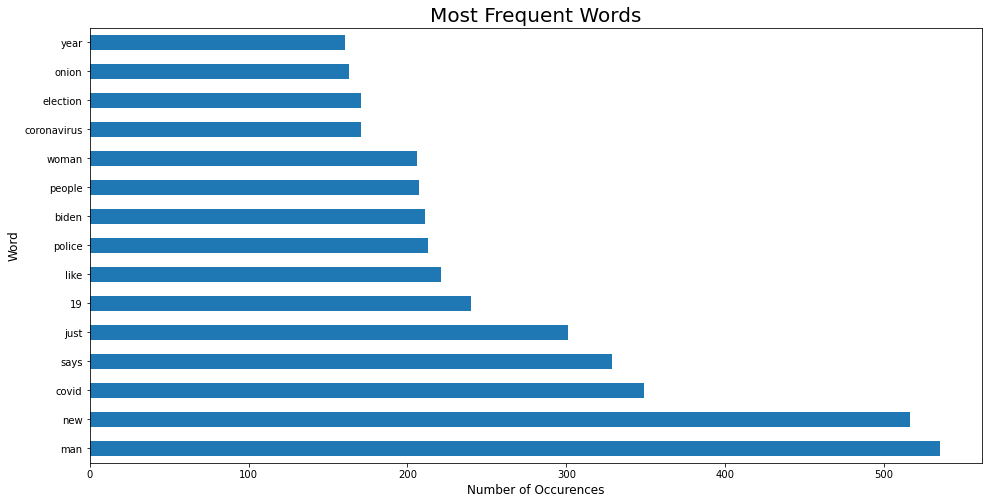

In [774]:
# basic count vectorizer to see the most common words 
cv = CountVectorizer(stop_words='english')
cv.fit(onions['title'])
X = cv.transform(onions['title'])
df = pd.DataFrame(X.todense(), columns=cv.get_feature_names())

# Plot most frequently found words in the dataframe
plt.figure(figsize=(16,8))
df.sum().sort_values(ascending=False).head(15).plot(kind='barh')

plt.xlabel('Number of Occurences',size=12)
plt.ylabel('Word', size=12);

plt.title('Most Frequent Words', size =20);

# Countvectorizer - Logistic Regression Estimator

The baseline score to beat was 0.524
The train accuracy score is 0.966
The test accuracy score is 0.835


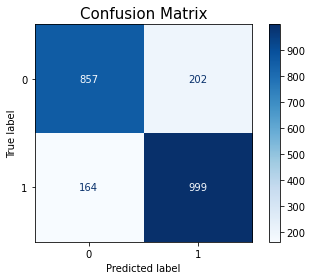

In [780]:
# set up X and y for modeling. y will be our target which is the subreddit from where the post came from.
X= onions['title']

y = onions['subreddit']

# Train test split the data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=99, test_size = .25)

# set up pipeline for the transformer and estimator
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())])

# pipeline parameters that we will Gridsearch over
pipe_params = {
    'cvec__max_features': [6_000, 7_000, 8_000, 9_000],
    'cvec__min_df': [2, 3, 4],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__stop_words': [None, 'english']}

# instantiate grid search with the pipeline parameters and 5 folds
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5)

# fit the grid search on the train data
gs.fit(X_train, y_train)

# baseline score
print(f'The baseline score to beat was {round(y.mean(),3)}')

# train accuracy score from gridsearch
print(f'The train accuracy score is {round(gs.score(X_train, y_train),3)}')

# test accuracy score from gridsearch
print(f'The test accuracy score is {round(gs.score(X_test, y_test),3)}')

# predictions from the test 
preds = gs.predict(X_test)

# set up confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# plot confusion matrix 
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d')
plt.title('Confusion Matrix', size=15);

# TFIDF - Multinomial Naive Bayes Estimator

The baseline score to beat was 0.524
The train accuracy score is 0.921
The test accuracy score is 0.827


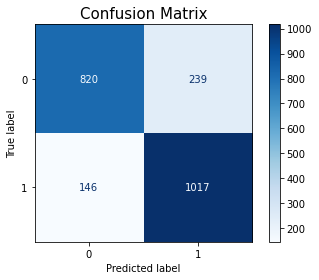

In [781]:
# Pipeline with transformer and estimator 
pipe_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())])

# Parameters for Gridsearch
pipe_tfidf_params = {
    'tfidf__max_features': [6_000,7_000,8_000, 9_000],
    'tfidf__stop_words': [None, 'english'],
    'tfidf__ngram_range': [(1,1), (1,2)]}

# Run and fit Gridsearch with pipeline and parameters
gs_tfidf = GridSearchCV(pipe_tfidf, param_grid = pipe_tfidf_params, cv=5)
gs_tfidf.fit(X_train, y_train)

# baseline score
print(f'The baseline score to beat was {round(y.mean(),3)}')

# train accuracy score from gridsearch
print(f'The train accuracy score is {round(gs_tfidf.score(X_train, y_train),3)}')

# test accuracy score from gridsearch
print(f'The test accuracy score is {round(gs_tfidf.score(X_test, y_test),3)}')

# predictions from the test, set up confusion matrix, plot confusion matrix 
preds_tfidf = gs_tfidf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds_tfidf).ravel()
plot_confusion_matrix(gs_tfidf, X_test, y_test, cmap='Blues', values_format='d')
plt.title('Confusion Matrix', size=15);

# CountVectorizer - Random Forest Estimator

The Training accuracy score is 0.823
The Testing accuracy score is 0.784


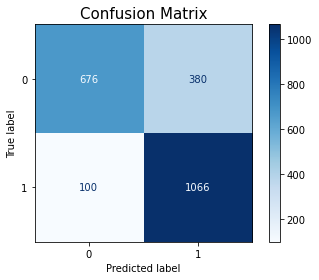

In [798]:
# Instantiate countvectorizer
cv = CountVectorizer()

# Transform and fit X_train and transform X_test
X_train = cv.fit_transform(X_train)
X_test = cv.transform(X_test)

# Instantiate Random Forest Classifier
forest = RandomForestClassifier()

# Parameters for GridSearch
forest_params = {
      'bootstrap': [False],
      'n_estimators': [500],
      'max_depth': [80,90],
      'max_features': ['sqrt'],
      'min_samples_leaf': [5,10]}

# Run and fit Gridsearch with Forest model and forest_params
gs_rf = GridSearchCV(forest, param_grid=forest_params, cv=5, n_jobs=2)
gs_rf.fit(X_train, y_train)

# Print training accuracy score from Forest Gridsearch
print(f'The Training accuracy score is {round(gs_rf.score(X_train, y_train),3)}')

# Print testing accuracy score from Forest Gridsearch
print(f'The Testing accuracy score is {round(gs_rf.score(X_test, y_test),3)}')

# Predictions on X_test, set up confusion matrix, plot confusion matrix
preds_rf = gs_rf.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds_rf).ravel()
plot_confusion_matrix(gs_rf, X_test, y_test, cmap='Blues')
plt.title('Confusion Matrix', size=15);

# TFIDF - Support Vector Machine (SVM)

In [675]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import numpy as np

The Training accuracy score is 0.999
The Testing accuracy score is 0.874


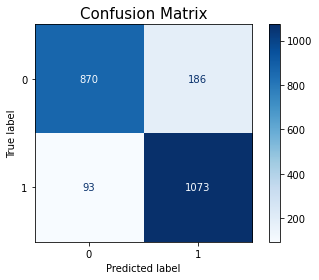

In [788]:
X = onions['title']
y = onions['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

# Pipeline for SVC 
pipe_svc = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc', SVC())])

# Parameters for SVC (after multiple gridsearches, settled on this combination)
params_svc = {
    'svc__kernel': ['rbf'],
    'svc__C': [1.3333],
    'svc__degree': [1]}

gs_svc = GridSearchCV(pipe_svc, param_grid=params_svc, cv=5)

gs_svc.fit(X_train,y_train)

# Print training accuracy score from Forest Gridsearch
print(f'The Training accuracy score is {round(gs_svc.score(X_train, y_train),3)}')

# Print testing accuracy score from Forest Gridsearch
print(f'The Testing accuracy score is {round(gs_svc.score(X_test, y_test),3)}')

# Predictions, set up confusion matrix, and plot confusion matrix 
preds_svc = gs_svc.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds_svc).ravel()
plot_confusion_matrix(gs_svc, X_test, y_test, cmap='Blues')
plt.title('Confusion Matrix', size=15);

# Results

In [796]:
# Create new datafram from predictions from best model (SVM-TFIDF)
results = pd.DataFrame(gs_svc.predict(X), columns=['predicted'])
results['actual'] = y
results['title'] = onions['title']
results.to_csv('results.csv')
results.sample(5)

,predicted,actual,title
3209,1,1,Tips For Going Through A Divorce
6303,0,0,Boxing event aimed at ending gun violence ends with Sacramento police fatally shooting man
7896,0,0,It's almost like internet isn't a thing
728,1,1,International Con Man Barack Obama Leaves U.S. With $85 Million In Campaign Fundraising (2008)
6448,0,0,Matthew Morrison to Ruin Christmas


In [797]:
# Dataframe of posts that my model got incorrect
incorrects = results[results['predicted'] != results['actual']]
incorrects.to_csv('incorrect_predictions.csv')
incorrects.head()

,predicted,actual,title
19,0,1,The PS5 launch is rough
26,0,1,Vatican probing Pope Francis’ Instagram ‘liking’ racy photo
27,0,1,Vatican Launches Probe After Pope’s Insta Account Likes Very Risqué ‘School Girl’ Pic
37,0,1,When your video goes VIRAL and you get on the RADIO
41,0,1,The Must-Have Xbox Series X Launch Titles
